In [9]:
import os, random, math, numpy as np, torch, matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")) + '/lib/')
from torch_geometric.data import Data
from torch_geometric.data import Data
from lib.blob_extraction import img_preprocess, blob_detect, get_nodes_pos
from lib.graph_generate import Delaunay_graph_generate
from lib.voronoi_generate import TransformVoronoi_331

from identity_rate import identity_rate, kept_frac 
TIP_NUM = 331

# ========== 通用小工具 ==========
def split_frames(d, N=TIP_NUM):
    T = d.x.size(0)//N
    XY = d.x[:, :2].view(T, N, 2).detach().cpu().numpy()
    return XY, T

def spatial_edges_of_frame(d, t, N=TIP_NUM):
    i0, i1 = t*N, (t+1)*N
    ei = d.edge_index
    m = (ei[0]>=i0)&(ei[0]<i1)&(ei[1]>=i0)&(ei[1]<i1)
    return (ei[:, m]-i0).detach().cpu().numpy()  # [2, E]

def viz_spatial_frame(d, t=0, N=TIP_NUM, out="viz_out/spatial_t.png"):
    """第 t 帧：节点 + 空间边（Delaunay）"""
    XY, T = split_frames(d, N)
    assert 0 <= t < T
    e = spatial_edges_of_frame(d, t, N)
    os.makedirs(os.path.dirname(out), exist_ok=True)
    plt.figure()
    plt.scatter(XY[t,:,0], XY[t,:,1], s=8)
    for u, v in e.T:
        x = [XY[t,u,0], XY[t,v,0]]; y = [XY[t,u,1], XY[t,v,1]]
        plt.plot(x, y, linewidth=0.5)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Spatial graph @ frame {t}")
    plt.savefig(out, dpi=200, bbox_inches="tight"); plt.close()
    print(f"[SAVE] {out}")

def temporal_edges_between(d, t, N=TIP_NUM):
    # 优先用独立字段；否则用 |i-j|==N 的启发式
    i0, i1 = t*N, (t+1)*N
    j0, j1 = (t+1)*N, (t+2)*N
    if hasattr(d, "temporal_edge_index") and d.temporal_edge_index is not None:
        tei = d.temporal_edge_index
    else:
        tei = d.edge_index[:, (d.edge_index[0]-d.edge_index[1]).abs()==N]
    m = (tei[0]>=i0)&(tei[0]<i1)&(tei[1]>=j0)&(tei[1]<j1)
    te = tei[:, m].detach().cpu().numpy()
    return np.vstack([te[0]-i0, te[1]-j0])  # 映射到 [0,N)

# def identity_rate(d, N=TIP_NUM):
#     XY, T = split_frames(d, N)
#     ok = 0; tot = 0
#     for t in range(T-1):
#         te = temporal_edges_between(d, t, N)
#         tot += te.shape[1]
#         ok  += int((te[0]==te[1]).sum())
#     return (ok / max(1, tot))

# ========== A. 检测效率 & 例图 ==========
def hist_detect_counts(raw_data_dir, label_csv=None, max_frames=None):
    """
    重新跑一遍检测，统计每帧 markers 数直方图（需要你已 import img_preprocess / blob_detect 等）
    label_csv: 若为 None，默认 raw_data_dir 的上一级有 targets.csv
    """
    import pandas as pd, cv2
    if label_csv is None:
        label_csv = os.path.join(os.path.abspath(os.path.join(raw_data_dir, "..")), "targets.csv")
    df = pd.read_csv(label_csv)
    rows = df.itertuples()
    counts = []
    for k, row in enumerate(rows):
        if max_frames and k>=max_frames: break
        img = cv2.imread(os.path.join(raw_data_dir, row.image_name))
        if img is None: continue
        proc = img_preprocess(img, erosion=False, kernel_size=1,
                              resize_x=300, resize_y=300,
                              binary_threshold=100,
                              circle_x_bias=-1, circle_y_bias=-2, circle_radius_bias=-14)
        kps = blob_detect(proc, minArea=10, blobColor=255,
                          minCircularity=0.01, minConvexity=0.01,
                          minInertiaRatio=0.01, thresholdStep=5,
                          minDistBetweenBlobs=3.0, minRepeatability=3)
        counts.append(len(kps))
    plt.figure()
    plt.hist(counts, bins=min(50, max(5, len(set(counts)))))
    plt.axvline(TIP_NUM, color='r', linestyle='--', label=f'Expected {TIP_NUM}')
    plt.xlabel("Detected markers per frame"); plt.ylabel("Count"); plt.legend()
    plt.title("Marker detection count histogram")
    os.makedirs("viz_out", exist_ok=True)
    p = "viz_out/detect_counts_hist.png"
    plt.savefig(p, dpi=200, bbox_inches="tight"); plt.close()
    print(f"[SAVE] {p}")

def overlay_detection_on_image(image_path, out_path):
    """单帧原图叠加：检测点(红) + Delaunay 边(细线)"""
    import cv2
    img = cv2.imread(image_path)
    proc = img_preprocess(img, erosion=False, kernel_size=1,
                          resize_x=300, resize_y=300,
                          binary_threshold=100,
                          circle_x_bias=-1, circle_y_bias=-2, circle_radius_bias=-14)
    kps = blob_detect(proc, minArea=10, blobColor=255,
                      minCircularity=0.01, minConvexity=0.01,
                      minInertiaRatio=0.01, thresholdStep=5,
                      minDistBetweenBlobs=3.0, minRepeatability=3)
    nodes_pos = get_nodes_pos(kps)

    # === 缩放还原 ===
    H_raw, W_raw = img.shape[:2]
    scale_x = W_raw / 300
    scale_y = H_raw / 300
    nodes_pos[:, 0] *= scale_x
    nodes_pos[:, 1] *= scale_y

    # 画点
    vis = img.copy()
    for (x,y) in nodes_pos.astype(int):
        cv2.circle(vis, (int(x), int(y)), 2, (0,0,255), -1)
    # 画 Delaunay
    edges = np.array(Delaunay_graph_generate(nodes_pos)).T
    for u,v in edges.T:
        x1,y1 = nodes_pos[u].astype(int); x2,y2 = nodes_pos[v].astype(int)
        cv2.line(vis, (x1,y1), (x2,y2), (100,200,100), 1)
    cv2.imwrite(out_path, vis); print(f"[SAVE] {out_path}")

def overlay_random_samples(raw_data_dir, label_csv=None, k=3):
    """随机抽 k 帧做叠加例图"""
    import pandas as pd
    if label_csv is None:
        label_csv = os.path.join(os.path.abspath(os.path.join(raw_data_dir, "..")), "targets.csv")
    df = pd.read_csv(label_csv)
    picks = df.sample(n=min(k, len(df)), random_state=42)
    os.makedirs("viz_out/overlay", exist_ok=True)
    for i, row in enumerate(picks.itertuples()):
        image_path = os.path.join(raw_data_dir, row.image_name)
        out = f"viz_out/overlay/overlay_{i}.png"
        overlay_detection_on_image(image_path, out)

# ========== B. 时序对齐可视化 ==========
def viz_temporal_edges(d, t=0, N=TIP_NUM, out="viz_out/temporal_t_to_t1.png"):
    XY, T = split_frames(d, N)
    assert 0 <= t < T-1
    te = temporal_edges_between(d, t, N)  # [2, E]
    os.makedirs(os.path.dirname(out), exist_ok=True)
    plt.figure()
    plt.scatter(XY[t,:,0],   XY[t,:,1],   s=8, label=f"t={t}")
    plt.scatter(XY[t+1,:,0], XY[t+1,:,1], s=8, marker="x", label=f"t={t+1}")
    for u, v in te.T:
        x = [XY[t,u,0], XY[t+1,v,0]]; y = [XY[t,u,1], XY[t+1,v,1]]
        plt.plot(x, y, linewidth=0.6, alpha=0.7)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Temporal edges: frame {t} → {t+1}  (E={te.shape[1]})")
    plt.legend()
    plt.savefig(out, dpi=200, bbox_inches="tight"); plt.close()
    print(f"[SAVE] {out}")

def viz_temporal_map(d, t=0, N=TIP_NUM, out="viz_out/temporal_map_t.png"):
    te = temporal_edges_between(d, t, N)
    M = np.zeros((N, N), dtype=np.float32); M[te[0], te[1]] = 1.0
    os.makedirs(os.path.dirname(out), exist_ok=True)
    plt.figure()
    plt.imshow(M, interpolation="nearest", aspect="auto")
    plt.colorbar(); plt.xlabel(f"frame {t+1} index j"); plt.ylabel(f"frame {t} index i")
    plt.title(f"Temporal adjacency t→t+1 (ideal=diagonal)")
    plt.savefig(out, dpi=200, bbox_inches="tight"); plt.close(); print(f"[SAVE] {out}")

def viz_tracks_3frames(d, t0=0, N=TIP_NUM, out="viz_out/tracks_t0t1t2.png", max_tracks=150):
    """把 t0→t1→t2 的“同一节点轨迹”画成彩色折线（需两段时序边可链）"""
    XY, T = split_frames(d, N)
    assert T>=3 and 0 <= t0 < T-2
    te01 = temporal_edges_between(d, t0,   N)  # [2,E01]
    te12 = temporal_edges_between(d, t0+1, N)  # [2,E12]
    # 构造字典 i@t0 -> j@t1 -> k@t2
    map01 = {int(u): int(v) for u,v in te01.T}
    map12 = {int(u): int(v) for u,v in te12.T}
    chains = []
    for u0,v1 in map01.items():
        if v1 in map12:
            chains.append((u0, v1, map12[v1]))
    os.makedirs(os.path.dirname(out), exist_ok=True)
    plt.figure()
    plt.scatter(XY[t0,:,0],   XY[t0,:,1],   s=6)
    plt.scatter(XY[t0+1,:,0], XY[t0+1,:,1], s=6, marker="x")
    plt.scatter(XY[t0+2,:,0], XY[t0+2,:,1], s=6, marker="^")
    # 画最多 max_tracks 条轨迹
    for i, (i0,i1,i2) in enumerate(chains[:max_tracks]):
        x = [XY[t0,i0,0], XY[t0+1,i1,0], XY[t0+2,i2,0]]
        y = [XY[t0,i0,1], XY[t0+1,i1,1], XY[t0+2,i2,1]]
        plt.plot(x, y, linewidth=0.7, alpha=0.8)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Tracks over frames {t0},{t0+1},{t0+2} (drawn={min(len(chains),max_tracks)})")
    plt.savefig(out, dpi=200, bbox_inches="tight"); plt.close()
    print(f"[SAVE] {out}")

# ========== C. 边统计 ==========
def frame_degree_and_length_stats(d, N=TIP_NUM):
    """返回每帧的度数组/边长数组（仅空间边）"""
    XY, T = split_frames(d, N)
    degs_per_frame = []
    lens_per_frame = []
    for t in range(T):
        e = spatial_edges_of_frame(d, t, N)   # [2,E]
        # 去重成无向边
        undirected = set()
        for u,v in e.T:
            a,b = int(min(u,v)), int(max(u,v))
            undirected.add((a,b))
        deg = np.zeros(N, dtype=np.int32)
        lens = []
        for a,b in undirected:
            deg[a]+=1; deg[b]+=1
            dx = XY[t,a,0]-XY[t,b,0]; dy = XY[t,a,1]-XY[t,b,1]
            lens.append(math.hypot(dx,dy))
        degs_per_frame.append(deg)
        lens_per_frame.append(np.array(lens, dtype=np.float32))
    return degs_per_frame, lens_per_frame

def viz_degree_boxplot(d, N=TIP_NUM, out="viz_out/degree_box.png"):
    degs_per_frame, _ = frame_degree_and_length_stats(d, N)
    os.makedirs(os.path.dirname(out), exist_ok=True)
    plt.figure()
    plt.boxplot([deg for deg in degs_per_frame], showfliers=False)
    plt.xlabel("frame index"); plt.ylabel("node degree (spatial)")
    plt.title("Per-frame spatial degree distribution")
    plt.savefig(out, dpi=200, bbox_inches="tight"); plt.close(); print(f"[SAVE] {out}")

def viz_edgelength_hist(d, N=TIP_NUM, out="viz_out/edgelength_hist.png"):
    _, lens_per_frame = frame_degree_and_length_stats(d, N)
    os.makedirs(os.path.dirname(out), exist_ok=True)
    plt.figure()
    all_lens = np.concatenate(lens_per_frame) if len(lens_per_frame)>0 else np.array([])
    plt.hist(all_lens, bins=50)
    plt.xlabel("edge length (canonical units)")
    plt.ylabel("count")
    plt.title("Spatial edge length distribution (all frames)")
    plt.savefig(out, dpi=200, bbox_inches="tight"); plt.close(); print(f"[SAVE] {out}")

# ========== D. 标签校准 ==========
def viz_label_distribution(graphs, out_prefix="viz_out/labels"):
    os.makedirs(os.path.dirname(out_prefix), exist_ok=True)
    Y = np.stack([g.y.detach().cpu().numpy() for g in graphs], axis=0)  # [M,2]
    y2 = Y[:,0]; y6 = Y[:,1]
    # 直方图
    plt.figure(); plt.hist(y2, bins=50); plt.xlabel("pose_2"); plt.ylabel("count"); plt.title("pose_2 histogram")
    plt.savefig(out_prefix+"_pose2_hist.png", dpi=200, bbox_inches="tight"); plt.close()
    plt.figure(); plt.hist(y6, bins=50); plt.xlabel("pose_6"); plt.ylabel("count"); plt.title("pose_6 histogram")
    plt.savefig(out_prefix+"_pose6_hist.png", dpi=200, bbox_inches="tight"); plt.close()
    # 散点
    plt.figure(); plt.scatter(y2, y6, s=8, alpha=0.6); plt.xlabel("pose_2"); plt.ylabel("pose_6"); plt.title("pose_2 vs pose_6")
    plt.grid(alpha=0.3)
    plt.savefig(out_prefix+"_scatter.png", dpi=200, bbox_inches="tight"); plt.close()
    print(f"[SAVE] {out_prefix}_pose2_hist.png / _pose6_hist.png / _scatter.png")

# 简单 baseline：MLP（“只用最后一帧” vs “全 k 帧”）
def mlp_baseline_last_vs_all(graphs, k_frames=5, N=TIP_NUM, hidden=256, epochs=30, lr=1e-3, device=None):
    """
    X_last: 取最后一帧的 x 特征，做 (N*3) 展平
    X_all : 取全部 k 帧，做 (k*N*3) 展平
    用同一个 MLP 回归 y=[pose_2, pose_6]，分别训练两次对比
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    def make_XY(graphs, use_all=False):
        Xs, Ys = [], []
        for g in graphs:
            T = g.x.size(0)//N
            if use_all:
                x = g.x[-k_frames*N:].view(-1)  # k*N*3
            else:
                x = g.x[-N:].view(-1)           # N*3
            Xs.append(x.detach().cpu().numpy())
            Ys.append(g.y.detach().cpu().numpy())
        X = torch.tensor(np.stack(Xs,0), dtype=torch.float32)
        Y = torch.tensor(np.stack(Ys,0), dtype=torch.float32)
        return X, Y

    class MLP(torch.nn.Module):
        def __init__(self, in_dim, hidden=hidden):
            super().__init__()
            self.net = torch.nn.Sequential(
                torch.nn.Linear(in_dim, hidden), torch.nn.ReLU(),
                torch.nn.Linear(hidden, hidden), torch.nn.ReLU(),
                torch.nn.Linear(hidden, 2)
            )
        def forward(self, x): return self.net(x)

    def train_one(X, Y):
        in_dim = X.size(1)
        model = MLP(in_dim).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = torch.nn.L1Loss()
        for ep in range(epochs):
            model.train(); opt.zero_grad()
            out = model(X.to(device))
            loss = loss_fn(out, Y.to(device))
            loss.backward(); opt.step()
        model.eval()
        with torch.no_grad():
            pred = model(X.to(device))
            mae = (pred - Y.to(device)).abs().mean(0).cpu().numpy()  # [2]
        return mae

    X_last, Y = make_XY(graphs, use_all=False)
    X_all,  _ = make_XY(graphs, use_all=True)
    mae_last = train_one(X_last, Y)
    mae_all  = train_one(X_all,  Y)
    print(f"[Baseline-MLP] last-frame MAE:  Y={mae_last[0]:.4f} | θ={mae_last[1]:.4f}")
    print(f"[Baseline-MLP] all-{k_frames}f MAE: Y={mae_all[0]:.4f} | θ={mae_all[1]:.4f}")
    return mae_last, mae_all

# ========== E. 失败样本画册 ==========
def worst_k_on_val(model, val_dataset, device=None, k=5, N=TIP_NUM):
    """逐样本评估 val，返回误差最大的 k 个 index（按 MAE 和）"""
    from torch_geometric.loader import DataLoader
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    errs = []
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(loader):
            batch = batch.to(device)
            out = model(batch)
            tgt = batch.y.view(out.size()).to(device)
            err = (out - tgt).abs().mean().item()  # 也可分开两维存
            errs.append((err, i))
    errs.sort(reverse=True)
    idx = [j for _, j in errs[:k]]
    return idx, errs

def export_debug_for_sample(d, out_dir="viz_out/debug_seq", N=TIP_NUM):
    """打包导出：单个序列的空间/时序图、矩阵图、曲线、位移直方图"""
    os.makedirs(out_dir, exist_ok=True)
    XY, T = split_frames(d, N)
    # 空间图：首帧/末帧
    plt.figure(); e0 = spatial_edges_of_frame(d, 0, N)
    plt.scatter(XY[0,:,0], XY[0,:,1], s=8)
    for u,v in e0.T: plt.plot([XY[0,u,0],XY[0,v,0]],[XY[0,u,1],XY[0,v,1]], linewidth=0.5)
    plt.gca().set_aspect("equal", adjustable="box"); plt.title("Spatial graph @ t=0")
    plt.savefig(os.path.join(out_dir,"spatial_t0.png"), dpi=200, bbox_inches="tight"); plt.close()

    plt.figure(); eL = spatial_edges_of_frame(d, T-1, N)
    plt.scatter(XY[T-1,:,0], XY[T-1,:,1], s=8)
    for u,v in eL.T: plt.plot([XY[T-1,u,0],XY[T-1,v,0]],[XY[T-1,u,1],XY[T-1,v,1]], linewidth=0.5)
    plt.gca().set_aspect("equal", adjustable="box"); plt.title(f"Spatial graph @ t={T-1}")
    plt.savefig(os.path.join(out_dir,f"spatial_t{T-1}.png"), dpi=200, bbox_inches="tight"); plt.close()

    # 时序边：前两段 + 矩阵
    if T>=2:
        viz_temporal_edges(d, t=0, N=N, out=os.path.join(out_dir,"temporal_0to1.png"))
        viz_temporal_map(d,   t=0, N=N, out=os.path.join(out_dir,"temporal_map_0to1.png"))
    if T>=3:
        viz_temporal_edges(d, t=1, N=N, out=os.path.join(out_dir,"temporal_1to2.png"))
        viz_temporal_map(d,   t=1, N=N, out=os.path.join(out_dir,"temporal_map_1to2.png"))

    # 轨迹
    if T>=3:
        viz_tracks_3frames(d, t0=0, N=N, out=os.path.join(out_dir,"tracks_t0t1t2.png"))

    # 度数箱线图 & 边长直方图
    viz_degree_boxplot(d, N=N, out=os.path.join(out_dir,"degree_box.png"))
    viz_edgelength_hist(d, N=N, out=os.path.join(out_dir,"edgelength_hist.png"))

    # 位移分布
    if T>=2:
        # 最近邻位移分布（近似 dmatch 量级）
        A = XY[0]; B = XY[1]
        D = ((A[:,None,:]-B[None,:,:])**2).sum(-1)**0.5
        nn = D.min(axis=1)
        plt.figure(); plt.hist(nn, bins=40)
        plt.xlabel("nearest-neighbor displacement (t0→t1)"); plt.ylabel("count")
        plt.title("dmatch histogram (t0→t1)")
        plt.savefig(os.path.join(out_dir,"dmatch_hist_0to1.png"), dpi=200, bbox_inches="tight"); plt.close()


In [10]:
# Light Version 

train_data_dir = r'../result/train'
train_pt = os.path.join(train_data_dir,"Train_data_list.pt")  # 按你的路径
graphs = torch.load(train_pt, map_location="cpu")


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
raw_data_dir = os.path.join(project_root, "data", "331", "model_surface2d", "frames_bw")  # 改成你的
# A1: markers 直方图（2000 帧抽样就够）
hist_detect_counts(raw_data_dir, max_frames=2000)

# A2: 原图叠加 2–3 张
overlay_random_samples(raw_data_dir, k=3)

# 先裁成与训练一致的 k 帧（比如 k=5）
def k_last_frames_subgraph(d, k=5, N=331):
    from torch_geometric.data import Data
    T = d.x.size(0)//N; i0,i1=(T-k)*N, T*N
    ei = d.edge_index; m=(ei[0]>=i0)&(ei[0]<i1)&(ei[1]>=i0)&(ei[1]<i1)
    dd = Data(x=d.x[i0:i1].clone(), edge_index=(ei[:,m]-i0).contiguous(), y=d.y.clone())
    if hasattr(d,"temporal_edge_index") and d.temporal_edge_index is not None:
        m2=(d.temporal_edge_index[0]>=i0)&(d.temporal_edge_index[0]<i1)&(d.temporal_edge_index[1]>=i0)&(d.temporal_edge_index[1]<i1)
        dd.temporal_edge_index=(d.temporal_edge_index[:,m2]-i0).contiguous()
    return dd

# 选“最好/最差”的两个样本（按 IdentityRate-nn_over_frames 排）
pairs=[]
for i,g in enumerate(graphs):
    d5=k_last_frames_subgraph(g, k=5, N=331)
    pairs.append((identity_rate(d5,331,"nn_over_frames"), i))
pairs.sort()
bad_idx=pairs[0][1]; good_idx=pairs[-1][1]

# for idx,name in [(good_idx,"good_seq"), (bad_idx,"bad_seq")]:
#     d5=k_last_frames_subgraph(graphs[idx], k=5, N=331)
#     viz_temporal_edges(d5, t=0, N=331, out=f"viz_out/{name}/temporal_0to1.png")
#     viz_temporal_map(d5,   t=0, N=331, out=f"viz_out/{name}/temporal_map_0to1.png")
#     if d5.x.size(0)//331 >= 3:
#         viz_tracks_3frames(d5, t0=0, N=331, out=f"viz_out/{name}/tracks_t0t1t2.png")
N = 331
for idx, name in [(good_idx, "good_seq"), (bad_idx, "bad_seq")]:
    d5  = k_last_frames_subgraph(graphs[idx], k=5, N=N)
    nn  = identity_rate(d5, N, mode="nn_over_frames")
    gir = identity_rate(d5, N, mode="geom_over_edges", use_hungarian=True)  # 可选展示
    kf  = kept_frac(d5, N)

    tag = f"NN{nn:.3f}_GIR{gir:.3f}_kept{kf:.2f}"
    outdir = f"viz_out/{name}"
    os.makedirs(outdir, exist_ok=True)

    viz_temporal_edges(d5, t=0, N=N, out=f"{outdir}/temporal_0to1_{tag}.png")
    viz_temporal_map(d5,   t=0, N=N, out=f"{outdir}/temporal_map_0to1_{tag}.png")
    if d5.x.size(0)//N >= 3:
        viz_tracks_3frames(d5, t0=0, N=N, out=f"{outdir}/tracks_t0t1t2_{tag}.png")

# 3) 一张“空间结构没问题”的对照图（C 的精简）
d5 = k_last_frames_subgraph(graphs[good_idx], k=5, N=331)
viz_spatial_frame(d5, t=0, N=331, out="viz_out/good_seq/spatial_t0.png")

#pose_2 / pose_6 直方图 + 二者散点（校准大致合理即可）。

viz_label_distribution(graphs, out_prefix="viz_out/labels")


[SAVE] viz_out/detect_counts_hist.png
[SAVE] viz_out/overlay/overlay_0.png
[SAVE] viz_out/overlay/overlay_1.png
[SAVE] viz_out/overlay/overlay_2.png
[SAVE] viz_out/good_seq/temporal_0to1_NN1.000_GIR1.000_kept0.90.png
[SAVE] viz_out/good_seq/temporal_map_0to1_NN1.000_GIR1.000_kept0.90.png
[SAVE] viz_out/good_seq/tracks_t0t1t2_NN1.000_GIR1.000_kept0.90.png
[SAVE] viz_out/bad_seq/temporal_0to1_NN0.569_GIR1.000_kept0.80.png
[SAVE] viz_out/bad_seq/temporal_map_0to1_NN0.569_GIR1.000_kept0.80.png
[SAVE] viz_out/bad_seq/tracks_t0t1t2_NN0.569_GIR1.000_kept0.80.png
[SAVE] viz_out/good_seq/spatial_t0.png
[SAVE] viz_out/labels_pose2_hist.png / _pose6_hist.png / _scatter.png


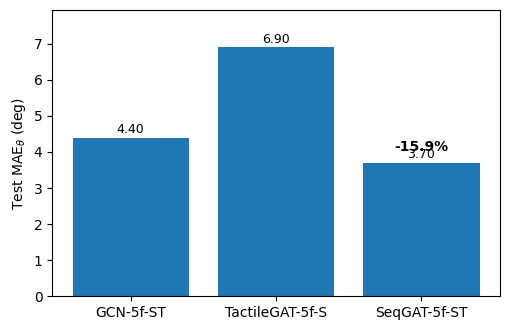

In [13]:
import numpy as np, matplotlib.pyplot as plt
labels = ["GCN-5f-ST", "TactileGAT-5f-S", "SeqGAT-5f-ST"]
theta  = np.array([4.40, 6.90, 3.70])  # ← 用你的 test MAE_θ
best_baseline = theta[:-1].min()
impr = (best_baseline - theta[-1]) / best_baseline * 100.0

fig, ax = plt.subplots(figsize=(5.2,3.4))
bars = ax.bar(labels, theta)
ax.set_ylabel("Test MAE$_\\theta$ (deg)")
ax.set_ylim(0, max(theta)*1.15)
for b, v in zip(bars, theta):
    ax.text(b.get_x()+b.get_width()/2, v+0.05, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
ax.text(bars[-1].get_x()+bars[-1].get_width()/2, theta[-1]+0.25,
        f"-{impr:.1f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout(); plt.savefig("main_bar_theta_test.png", dpi=300)


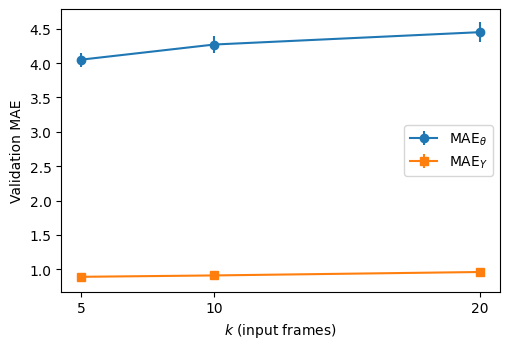

In [15]:
import numpy as np, matplotlib.pyplot as plt

k = np.array([5,10,20])
mae_theta_mean = np.array([4.05, 4.27, 4.45])
mae_theta_std  = np.array([0.10, 0.12, 0.15])
mae_Y_mean     = np.array([0.89, 0.91, 0.96])
mae_Y_std      = np.array([0.03, 0.03, 0.04])


fig, ax = plt.subplots(figsize=(5.2,3.6))
ax.errorbar(k, mae_theta_mean, yerr=mae_theta_std, marker='o', label="MAE$_\\theta$")
ax.errorbar(k, mae_Y_mean,     yerr=mae_Y_std,     marker='s', label="MAE$_Y$")
ax.set_xlabel("$k$ (input frames)"); ax.set_ylabel("Validation MAE")
ax.set_xticks([5,10,20]); ax.legend(); plt.tight_layout()
plt.savefig("k_ablation.png", dpi=300)
